## Figure 3 - Result of geodetic inversion

In [2]:
%matplotlib inline
import os
import h5py
import numpy as np
from matplotlib import pyplot as plt, ticker
from mintpy.utils import readfile, writefile, utils as ut, plot as pp
from mintpy.simulation.plot import *
from mintpy import view

work_dir = os.path.expanduser('~/development/2019_Kirishima/Shinmoe_model')
os.chdir(work_dir)
print('Go to directory', work_dir)

dem_file = os.path.expanduser('~/insarlab/Kirishima/ShinmoeAlosDT73/mintpy/inputs/gsi10m.dem.wgs84')

# inversion model
inv_dir = os.path.expanduser('~/insarlab/Kirishima/Model/Shinmoe_2008/invert_1_2_C')
model_name = inv_dir[-1]

# profile/transection position
profile_hz = [[31.9139, 130.8660],  # [[94,  60],  130.865
              [31.9139, 130.9050]]  #  [94,  170]]
profile_up = [[31.9300, 130.8847],  # [[50,  125],
              [31.8970, 130.8847]]  #  [140, 125]]

Go to directory /Users/yunjunz/development/2019_Kirishima/Shinmoe_model


## Geodetic modeling with GBIS

### 1. [Prepare GBIS input file](prep_GBIS.ipynb)

### 2. Run GBIS in Matlab

### 3. Convert GBIS inversion result into HDF5 file

In [3]:
# GBIS inversion result --> HDF5 file
inv_files = [os.path.join(inv_dir, 'ShinmoeAlosDT73_20081012_20100302.h5'),
             os.path.join(inv_dir, 'ShinmoeAlosAT424_20080929_20100520.h5')]
if not all(os.path.isfile(i) for i in inv_files):
    mat_file = os.path.join(inv_dir, '{}.mat'.format(os.path.basename(inv_dir)))
    cmd = 'load_gbis.py {} --nodisplay '.format(mat_file)
    print(cmd)
    !{cmd}
print('all GBIS inversion result HDF5 files exist.')

all GBIS inversion result HDF5 files exist.


## Plot (horizontal layout)

save figure to /Users/yunjunz/development/2019_Kirishima/Shinmoe_model/model_map_C.png


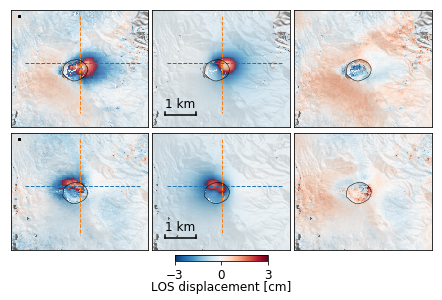

In [27]:
## Figure 3 - Inversion result
ds_names = ['data', 'model', 'residual']

# crater ring lon/lat
crater_lonlat_file = os.path.expanduser('~/development/2019_Kirishima/Shinmoe_crater_lonlat.xy')
fc = np.loadtxt(crater_lonlat_file, dtype=bytes, comments='>').astype(float)
crater_lons = fc[:,0]
crater_lats = fc[:,1]

# read data - map
data_list = []
cmd_list = []
for inv_file in inv_files:
    for ds_name in ds_names:
        data = readfile.read(inv_file, datasetName=ds_name)[0] * 100.0 #cm
        data_list.append(data)
        cmd = 'view.py {} {}'.format(inv_file, ds_name)
        cmd_list.append(cmd)

# plot
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=[6.5, 4], sharex=True, sharey=True)
axs = axs.flatten()

dmin, dmax = -5, 5
for i in range(len(data_list)):
    ax = axs[i]
    # prepare view.py command line
    cmd = cmd_list[i]+' -u cm -v {} {} '.format(dmin, dmax)
    cmd += ' --noverbose --notitle --nocbar --notick --ref-size 2 --fontsize 12 '
    cmd += ' --wrap --wrap-range -3 3 -c RdBu_r '
    cmd += ' --sub-lat 31.892 31.932 --sub-lon 130.861 130.908 '
    cmd += ' --scalebar 0.3 0.2 0.1 --scalebar-pad 0.1 '
    #cmd += ' --dem {} --dem-noshade --contour-step 100 --contour-smooth 0.0 --alpha 0.8 '.format(dem_file)
    cmd += ' --dem {} --dem-nocontour --shade-az 45 '.format(dem_file)
    if i in [0,2,3,5]:
        cmd += ' --noscalebar '
    if i in [1,2,4,5]:
        cmd += ' --noreference '
    # call view.py
    d_v, atr, inps = view.prep_slice(cmd)
    #inps.colormap = cmap
    ax, inps, im, cbar = view.plot_slice(ax, d_v, atr, inps)
    # plot profile location on data/model subplots only
    if i in [0,1,3,4]:
        [[y0,x0], [y1,x1]] = profile_hz
        ax.plot([x0,x1], [y0,y1], '--', lw=1, c=pp.mplColors[0])
        [[y0,x0], [y1,x1]] = profile_up
        ax.plot([x0,x1], [y0,y1], '--', lw=1, c=pp.mplColors[1])
    # plot the ring of the crater
    ax.plot(crater_lons, crater_lats, 'k-', lw=0.5)
fig.subplots_adjust(wspace=0.03, hspace=-0.1, left=0.05, right=0.95, top=0.95, bottom=0.05)

# colorbar
cax = fig.add_axes([0.4, 0.045, 0.2, 0.02])
cbar = plt.colorbar(im, cax=cax, orientation='horizontal', ticks=[-3, 0, 3])
cbar.ax.tick_params(labelsize=font_size)
cbar.set_label('LOS displacement [cm]', fontsize=font_size, labelpad=-1)

# output
out_file = os.path.abspath('model_map_{}.png'.format(model_name))
plt.savefig(out_file, bbox_inches='tight', transparent=True, dpi=fig_dpi)
print('save figure to', out_file)
plt.show()

save figure to /Users/yunjunz/development/2019_Kirishima/Shinmoe_model/model_profile_C.png


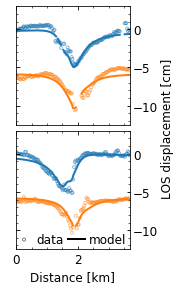

In [37]:
## Figure 3 - Inversion result
ds_names = ['data', 'model']

# read transection data
txn_hz_list = []
txn_up_list = []
for inv_file in inv_files:
    for ds_name in ds_names:
        data, atr = readfile.read(inv_file, datasetName=ds_name)
        txn_hz = ut.transect_lalo(data, atr, start_lalo=profile_hz[0], end_lalo=profile_hz[1])
        txn_up = ut.transect_lalo(data, atr, start_lalo=profile_up[0], end_lalo=profile_up[1])
        txn_hz_list.append(txn_hz)
        txn_up_list.append(txn_up)

# plot
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=[1.75, 3.75], sharex=True, sharey=True)
for i in range(len(axs)):
    ax = axs[i]
    # hz / up profile
    off = 0
    for txn_list, c in zip([txn_hz_list, txn_up_list], pp.mplColors[0:2]):
        txn = txn_list[i*2]
        ax.scatter(txn['distance']/1000.0, txn['value']*100.0 + off,
                   facecolors='none', edgecolors=c, s=3**2, alpha=0.5, label='data')
        txn = txn_list[i*2+1]
        ax.plot(txn['distance']/1000.0, txn['value']*100.0 + off, c=c, lw=2, label='model')
        off -= 5.5

    # axis format
    ax.set_xlim(0, np.max(txn_hz_list[0]['distance']/1000.0))
    ax.set_ylim(-12.5, 3)
    ax.yaxis.tick_right()
    ax.yaxis.set_label_position('right')
    ax.xaxis.set_minor_locator(ticker.AutoMinorLocator())
    ax.yaxis.set_major_locator(ticker.MultipleLocator(5))
    ax.yaxis.set_minor_locator(ticker.MultipleLocator(1))
    ax.tick_params(which='both', direction='in', labelsize=font_size, bottom=True, top=True, left=True, right=True)

fig.subplots_adjust(wspace=0.05, hspace=0.05, left=0.05, right=0.95, top=0.95, bottom=0.05)
#pp.set_shared_xlabel(axs, 'Distance [km]', font_size=font_size, position='bottom', labelpad=0.03)
#axs[0].set_ylabel('LOS displacement [cm]', fontsize=font_size)
axs[1].set_xlabel('Distance [km]', fontsize=font_size)
pp.set_shared_ylabel(axs, 'LOS displacement [cm]', font_size=font_size, position='right', labelpad=1.2)

# legend
ax = axs[1]
handles, labels = ax.get_legend_handles_labels()
leg = ax.legend(reversed(handles[0::2]), reversed(labels[0::2]), loc='lower right',
                fontsize=font_size, frameon=False, borderaxespad=-0.1, handletextpad=0,
                ncol=2, numpoints=3, columnspacing=0.1)
leg.legendHandles[0].set_edgecolors('black')
leg.legendHandles[1].set_color('black')

# output
out_file = os.path.abspath('model_profile_{}.png'.format(model_name))
plt.savefig(out_file, bbox_inches='tight', transparent=True, dpi=fig_dpi)
print('save figure to', out_file)
plt.show()

## Plot (vertial layout)

In [ ]:
## Figure 3 - Inversion result
ds_names = ['data', 'model', 'residual']

# crater ring lon/lat
crater_lonlat_file = os.path.expanduser('~/development/2019_Kirishima/Shinmoe_crater_lonlat.xy')
fc = np.loadtxt(crater_lonlat_file, dtype=bytes, comments='>').astype(float)
crater_lons = fc[:,0]
crater_lats = fc[:,1]

# read data - map
data_list = []
cmd_list = []
for ds_name in ds_names:
    for inv_file in inv_files:
        data = readfile.read(inv_file, datasetName=ds_name)[0] * 100.0 #cm
        data_list.append(data)
        cmd = 'view.py {} {}'.format(inv_file, ds_name)
        cmd_list.append(cmd)

# plot
fig, axs = plt.subplots(nrows=3, ncols=2, figsize=[4, 6], sharex=True, sharey=True)
axs = axs.flatten()

dmin, dmax = -5, 5
for i in range(len(data_list)):
    ax = axs[i]
    # prepare view.py command line
    cmd = cmd_list[i]+' -u cm -v {} {} '.format(dmin, dmax)
    cmd += ' --noverbose --notitle --nocbar --notick --noreference --scalebar-pad 0.08 --fontsize 12 '
    cmd += ' --wrap --wrap-range -3 3 -c jet '
    if i in [0,1,4,5]:
        cmd += ' --noscalebar '
    # call view.py
    d_v, atr, inps = view.prep_slice(cmd)
    ax, inps, im, cbar = view.plot_slice(ax, d_v, atr, inps)
    # plot profile location on data/model subplots only
    if i in [0,1,2,3]:
        [[y0,x0], [y1,x1]] = profile_hz
        ax.plot([x0,x1], [y0,y1], '--', lw=1, c=pp.mplColors[0])
        [[y0,x0], [y1,x1]] = profile_up
        ax.plot([x0,x1], [y0,y1], '--', lw=1, c=pp.mplColors[1])
    # plot the ring of the crater
    ax.plot(crater_lons, crater_lats, 'k-', lw=0.5)
fig.subplots_adjust(wspace=0.025, hspace=0.05, left=0.05, right=0.95, top=0.95, bottom=0.05)

# colorbar
cax = fig.add_axes([0.41, 0.09, 0.2, 0.015])
cbar = plt.colorbar(im, cax=cax, orientation='horizontal', ticks=[-3, 0, 3])
cbar.ax.tick_params(labelsize=font_size)
cbar.set_label('LOS displacement [cm]', fontsize=font_size, labelpad=-1)

# output
out_file = os.path.abspath('model_map_{}.png'.format(model_name))
#plt.savefig(out_file, bbox_inches='tight', transparent=True, dpi=fig_dpi)
print('save figure to', out_file)
plt.show()

In [ ]:
## Figure 3 - Inversion result
ds_names = ['data', 'model']

# read transection data
txn_hz_list = []
txn_up_list = []
for inv_file in inv_files:
    for ds_name in ds_names:
        data, atr = readfile.read(inv_file, datasetName=ds_name)
        txn_hz = ut.transect_lalo(data, atr, start_lalo=profile_hz[0], end_lalo=profile_hz[1])
        txn_up = ut.transect_lalo(data, atr, start_lalo=profile_up[0], end_lalo=profile_up[1])
        txn_hz_list.append(txn_hz)
        txn_up_list.append(txn_up)

# plot
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=[4, 2], sharex=True, sharey=True)
for i in range(len(axs)):
    ax = axs[i]
    # hz / up profile
    off = 0
    for txn_list, c in zip([txn_hz_list, txn_up_list], pp.mplColors[0:2]):
        txn = txn_list[i*2]
        ax.scatter(txn['distance']/1000.0, txn['value']*100.0 + off,
                   facecolors='none', edgecolors=c, s=3**2, alpha=0.5, label='data')
        txn = txn_list[i*2+1]
        ax.plot(txn['distance']/1000.0, txn['value']*100.0 + off, c=c, lw=2, label='model')
        off -= 5.5

    # axis format
    ax.set_xlim(0, np.max(txn_hz_list[0]['distance']/1000.0))
    ax.set_ylim(-11.5, 3)
    #ax.yaxis.tick_right()
    #ax.yaxis.set_label_position('right')
    ax.xaxis.set_minor_locator(ticker.AutoMinorLocator())
    ax.yaxis.set_major_locator(ticker.MultipleLocator(3))
    ax.yaxis.set_minor_locator(ticker.MultipleLocator(1))
    ax.tick_params(which='both', direction='in', labelsize=font_size, bottom=True, top=True, left=True, right=True)

fig.subplots_adjust(wspace=0.05, left=0.05, right=0.95, top=0.95, bottom=0.05)
axs[0].set_ylabel('LOS displacement [cm]', fontsize=font_size)
pp.set_shared_xlabel(axs, 'Distance [km]', font_size=font_size, position='bottom', labelpad=0.03)

# legend
ax = axs[0]
handles, labels = ax.get_legend_handles_labels()
leg = ax.legend(reversed(handles[0::2]), reversed(labels[0::2]), loc='lower left', fontsize=font_size, frameon=False, borderaxespad=0, handletextpad=0.25)
leg.legendHandles[0].set_edgecolors('black')
leg.legendHandles[1].set_color('black')

# output
out_file = os.path.abspath('model_profile_{}.png'.format(model_name))
#plt.savefig(out_file, bbox_inches='tight', transparent=True, dpi=fig_dpi)
print('save figure to', out_file)
plt.show()